<a href="https://colab.research.google.com/github/animesh-rai/x23194545_Sensitive_data_detection/blob/main/pii_detection_with_longformer_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Import packages
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter
import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gc
import re
import random
from itertools import chain

#import wandb
# Initialize wandb
#wandb.init(project="pii-detection")

#Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)

import time
# Capture the start time
start_time = time.time()
print("Start Time: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

Start Time:  2024-12-10 20:08:20


In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data
Load the training data from the provided JSON file and create a Hugging Face Dataset object. The data is split into training and evaluation sets.

In [ ]:
from transformers import AutoModel, pipeline
from transformers import LongformerTokenizerFast, LongformerForTokenClassification, Trainer, TrainingArguments

# Load dataset
dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
# Convert to DataFrame and preprocess
df = dataset['train'].to_pandas()

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Flatten labels to calculate class distribution
all_labels = [label for labels in df['labels'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()
print("Original Label Distribution:\n", label_counts)

# Define the target number of rows
total_rows = 1500
target_per_class = total_rows // len(label_counts)

# Separate majority and minority class data
majority_class = df[df['labels'].apply(lambda x: 'O' in x)]
minority_classes = df[df['labels'].apply(lambda x: any(label != 'O' for label in x))]

# Downsample the majority class ('O' label)
downsampled_majority = resample(
    majority_class,
    replace=False,
    n_samples=target_per_class,
    random_state=42
)

# Upsample the minority classes
balanced_data = [downsampled_majority]
for label in label_counts.index:
    if label != 'O':
        class_data = df[df['labels'].apply(lambda x: label in x)]
        if len(class_data) > 0:
            upsampled_data = resample(
                class_data,
                replace=True,
                n_samples=target_per_class if len(class_data) < target_per_class else len(class_data),
                random_state=42
            )
            balanced_data.append(upsampled_data)

# Combine the balanced data
balanced_df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
#balanced_df.to_csv('balanced_PII_dataset.csv', index=False)

# Verify the new class distribution
balanced_all_labels = [label for labels in balanced_df['labels'] for label in labels]
balanced_label_counts = pd.Series(balanced_all_labels).value_counts()
print("Balanced Label Distribution:\n", balanced_label_counts)
df = balanced_df

Original Label Distribution:
 O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64
Balanced Label Distribution:
 O                   2390247
B-NAME_STUDENT         3764
I-NAME_STUDENT         3451
I-STREET_ADDRESS       2680
I-PHONE_NUM            1059
B-URL_PERSONAL          669
B-EMAIL                 614
B-ID_NUM                531
B-PHONE_NUM             487
B-STREET_ADDRESS        268
B-USERNAME              142
I-URL_PERSONAL          119
I-ID_NUM                118
Name: count, dtype: int64


In [ ]:
all_labels = [label for sublist in df['labels'] for label in sublist]
unique_labels = list(set(all_labels))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}
all_labels = list(label2id.keys())  # Get all unique labels from mapping
num_labels = len(all_labels)  # Update the num_labels



In [ ]:

# Tokenizer and Model
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096", add_prefix_space=True)
model = LongformerForTokenClassification.from_pretrained("allenai/longformer-base-4096",from_flax=True,from_tf=True, num_labels=num_labels, id2label=id2label, label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Take the first 1500 rows
#df = df.iloc[:1500]

# Split Dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset_dict = datasets.DatasetDict({'train': train_dataset, 'test': test_dataset})

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All TF 2.0 model weights were used when initializing LongformerForTokenClassification.

All the weights of LongformerForTokenClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LongformerForTokenClassification for predictions without further training.


cuda


### Data Exploration

The dataset has four columns, 'document', 'tokens', 'labels', and 'trailing_whitespace'. Pandas can be used to visualize the dataset and get a better understanding of the structure.

In [ ]:
from datasets import Dataset

# Convert the DataFrame back to the Dataset format
dataset = Dataset.from_pandas(df)

print('Dataset length', len(dataset))
dataset

Dataset length 2970


Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'],
    num_rows: 2970
})

In [ ]:

df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,8642,Basavaraju Aakash Kumar\n\nboydcynthia@yahoo.c...,"[Basavaraju, Aakash, Kumar, \n\n, boydcynthia@...","[True, True, False, False, True, False, True, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN..."
1,11409,Final Assignment – “Design Thinking for Innova...,"[Final, Assignment, –, “, Design, Thinking, fo...","[True, True, True, False, True, True, True, Fa...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,..."
2,5716,ID meyermichelle\n\nReflection\n\nThe first to...,"[ID, meyermichelle, \n\n, Reflection, \n\n, Th...","[True, False, False, False, False, True, True,...","[O, B-USERNAME, O, O, O, O, O, O, O, O, O, O, ..."
3,4501,Free time\n\nand the\n\nelderly\n\nBefriending...,"[Free, time, \n\n, and, the, \n\n, elderly, \n...","[True, False, False, True, False, False, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,12876,Visualization\n\nAna Perez Challenge & Select...,"[Visualization, \n\n, Ana, Perez, , Challenge...","[False, False, True, True, False, True, True, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."


The pandas data frame produces a better visualization of the structure of the JSON file. Each row represents an essay written by a student. There are 6807 Rows in the data frame, each row representing a student essay. The column 'full text' contains the full essay. The 'Tokens' column contains the text separated by tokens. The trailing white space column is a list of placeholders indicating if a token contains a trailing white space. Finally, the labels column represents a label for each token. Each token is as one of our desired categories of PII, or 'O' if the token does not belong to PII a category.

We can view the first full essay as an example. A function 'format_text' is used to make the document more readable for humans.

In [ ]:
def format_text(text):
    # Add paragraph breaks
    formatted_text = text.replace('\n\n', '\n\n<p>\n\n')

    # Add bullet points to list items
    formatted_text = re.sub(r'•\s', '\n- ', formatted_text)

    # Handle remaining single newlines
    formatted_text = re.sub(r'(?<!\n)\n(?!\n)', ' ', formatted_text)

    # Remove leading and trailing spaces
    formatted_text = re.sub(r'\s+\n', '\n', formatted_text)
    formatted_text = re.sub(r'\n\s+', '\n', formatted_text)

    return formatted_text

# Example usage
raw_text = df['full_text'][0]

print(format_text(raw_text))

Basavaraju Aakash Kumar
<p>
boydcynthia@yahoo.com    I    holmespatrick
<p>
Example Reflection – Learning Launch
<p>
Challenge
<p>
I am a team leader in my company which is a infotainment and news channel and  run by upper house of Indian Parliament and in the company as i manage 30  people's design team and in the department my challenge to improve the  workflow of the different daily programme and weekly programme  because  some time all the team member engage to daily work which comes from the  different shows producer and due to that work our weekly shows suffer a lot and  we are not able to give required graphic on time and our management team point  out this problem regularly because we have very short period of time for  programming and we are not able to give quality in the graphics.
<p>
Selection
<p>
Our team has already gone through several design thinking tools which will help   us to meet our requirements and help us to improve our work on time. We have  to design some work

#### Distribution of the unique labels.

In [ ]:
# Count the frequency of each label in the 'train' dataset
label_freq = Counter(chain(*train_dataset['labels']))

# Display the frequency of each label
for label, freq in label_freq.items():
    print(f"Label: {label}, Frequency: {freq}")

Label: B-NAME_STUDENT, Frequency: 3018
Label: I-NAME_STUDENT, Frequency: 2764
Label: O, Frequency: 1910388
Label: B-EMAIL, Frequency: 501
Label: B-PHONE_NUM, Frequency: 397
Label: I-PHONE_NUM, Frequency: 876
Label: B-ID_NUM, Frequency: 427
Label: B-STREET_ADDRESS, Frequency: 212
Label: I-STREET_ADDRESS, Frequency: 2120
Label: B-URL_PERSONAL, Frequency: 526
Label: I-URL_PERSONAL, Frequency: 95
Label: B-USERNAME, Frequency: 120
Label: I-ID_NUM, Frequency: 92


In [ ]:
len(df)

2970

The data set is heavily distributed with tokens that do not belong to a PII category (ie 'O' labels). We will use a focal loss and class weights with our model to help with this class imbalance. This will help ensure our model does not simply predict all 'O's' given the large distribution of those labels.



#### Tokenization and Alignment of Labels
Explanations of the unique labels in the data set are below. These are the desired PII categories we seek to identify in the student essays. Note the tokens are split using a 'piece wise' tokenizer format.

##### Explanation of Labels:

B-EMAIL: Beginning of an email address.
B-ID_NUM: Beginning of an identification number.
B-NAME_STUDENT: Beginning of a student's name.
B-PHONE_NUM: Beginning of a phone number.
B-STREET_ADDRESS: Beginning of a street address.
B-URL_PERSONAL: Beginning of a personal URL.
B-USERNAME: Beginning of a username.
I-ID_NUM: Inside an identification number.
I-NAME_STUDENT: Inside a student's name.
I-PHONE_NUM: Inside a phone number.
I-STREET_ADDRESS: Inside a street address.
I-URL_PERSONAL: Inside a personal URL.
O: Outside of any named entity.


##### Tokenization Process:

Token Splitting: The text is split into tokens based on whitespace and punctuation.

Subword Tokenization: Each token is further split into subwords. For example, the word "unhappiness" might be split into "un", "happi", and "ness".

Label Alignment: Labels are aligned with the subword tokens. If a token is split into multiple subwords, the label for the original token is assigned to the first subword, and a special label (typically -100) is assigned to the subsequent subwords.
Here's an example of how a token and its label might be split and aligned:

Original token: "unhappiness" (Label: B-EMOTION) Subword tokens: ["un", "happi", "ness"] Aligned labels: [B-EMOTION, -100, -100]

The alignment ensures that the model learns to identify entities correctly even when tokens are split into subwords.

</font>

A function to tokenize the input data and align the labels with the tokenized inputs s also defined. his function handles the trailing whitespace correctly. The map function, which is included in the datasets library, is used to map the function to all of the documents in the data set. This will create the tokenized dataset required for the Hugging Face Deberta model.


In [ ]:
#Define function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=2048  # Longformer's max length
        #,return_offsets_mapping=True
    )

    batch_original_tokens = []
    batch_tokenized_tokens = []
    batch_label_ids = []
    batch_input_ids = []
    batch_attention_masks = []
    batch_token_type_ids = []

    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        original_tokens = examples["tokens"][i]
        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][i])

        previous_word_idx = None
        label_ids = []
        original_token_list = []
        tokenized_token_list = []
        input_id_list = []
        attention_mask_list = []
        token_type_id_list = []

        for j, word_idx in enumerate(word_ids):
            if word_idx is None:
                label_ids.append(-100)
                current_original_token = ''  # Special token
            elif word_idx == previous_word_idx:
                label_ids.append(-100)
                current_original_token = ''  # Subword token
            else:
                label_ids.append(label2id[label[word_idx]])
                current_original_token = original_tokens[word_idx]

            original_token_list.append(current_original_token)
            tokenized_token_list.append(tokenized_tokens[j])
            input_id_list.append(tokenized_inputs["input_ids"][i][j])
            attention_mask_list.append(tokenized_inputs["attention_mask"][i][j])
            if "token_type_ids" in tokenized_inputs:
                token_type_id_list.append(tokenized_inputs["token_type_ids"][i][j])
            else:
                token_type_id_list.append(0)
            previous_word_idx = word_idx  # Update for the next iteration

        batch_original_tokens.append(original_token_list)
        batch_tokenized_tokens.append(tokenized_token_list)
        batch_label_ids.append(label_ids)
        batch_input_ids.append(input_id_list)
        batch_attention_masks.append(attention_mask_list)
        batch_token_type_ids.append(token_type_id_list)

    # Include BERT-required columns
    return {
        "original_tokens": batch_original_tokens,
        "tokenized_tokens": batch_tokenized_tokens,
        "labels": batch_label_ids,
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_masks,
        "token_type_ids": batch_token_type_ids
    }

# Tokenize
tokenized_datasets = dataset_dict.map(tokenize_and_align_labels, batched=True)

gc.collect()

Map:   0%|          | 0/2376 [00:00<?, ? examples/s]

Map:   0%|          | 0/594 [00:00<?, ? examples/s]

95

It is important to ensure the tokenizer works correctly. The function below displays a comparison of the original tokens to the processed tokens.

In [ ]:
import datasets

# Function to print the first few elements of each relevant column
def print_comparison(dataset, num_elements=20):
    first_document = dataset[0]
    original_tokens = first_document['original_tokens'][:num_elements]
    tokenized_tokens = first_document['tokenized_tokens'][:num_elements]
    labels = first_document['labels'][:num_elements]
    input_ids = first_document['input_ids'][:num_elements]
    attention_mask = first_document['attention_mask'][:num_elements]
    token_type_ids = first_document['token_type_ids'][:num_elements]

    # Print the columns in a readable format
    for i in range(num_elements):
        print(f"Original Token: {original_tokens[i]:<15} | "
              f"Tokenized Token: {tokenized_tokens[i]:<20} | "
              f"Label: {labels[i]:<5} | "
              f"Input ID: {input_ids[i]:<10} | "
              f"Attention Mask: {attention_mask[i]:<5} | "
              f"Token Type ID: {token_type_ids[i]}")

# Example usage with the train dataset
print("Comparison of first 20 elements for the first document in the train dataset:")
print_comparison(tokenized_datasets['train'], num_elements=20)

Comparison of first 20 elements for the first document in the train dataset:
Original Token:                 | Tokenized Token: <s>                  | Label: -100  | Input ID: 0          | Attention Mask: 1     | Token Type ID: 0
Original Token: Waseem          | Tokenized Token: ĠW                   | Label: 2     | Input ID: 305        | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: ase                  | Label: -100  | Input ID: 3175       | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: em                   | Label: -100  | Input ID: 991        | Attention Mask: 1     | Token Type ID: 0
Original Token: Hamad           | Tokenized Token: ĠHam                 | Label: 6     | Input ID: 3600       | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: ad                   | Label: -100  | Input ID: 625        | Attention Mask: 1     | Token Type ID: 0
Origi

The tokenizer appears to have processed the original tokens correctly. We can remove the unnecessary column from the tokenized data set and only keep the columns required for training.

In [ ]:
# List of columns to keep
columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']

# Function to remove unnecessary columns
def remove_unnecessary_columns(dataset, columns_to_keep):
    return dataset.remove_columns([column for column in dataset.column_names if column not in columns_to_keep])

# Apply the function to both train and test datasets
tokenized_datasets['train'] = remove_unnecessary_columns(tokenized_datasets['train'], columns_to_keep)
tokenized_datasets['test'] = remove_unnecessary_columns(tokenized_datasets['test'], columns_to_keep)

### Longformer Model Training
Recall the data set is imbalanced, with the vast majority of labels belonging to a non-PII category 'O.' Class weights with a weighted loss function will be used to help with this imbalance. This means the model will put more focus on the minority classes and will put less weight on the majority classes when training. Also, a custom compute metrics function with a classification report is defined for evaluation.

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Creating a custom callback to track the loss at each epoch's end and log it for later plotting

In [ ]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the callback
loss_logger = LossLoggerCallback()

In [ ]:
# Define data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)

    def forward(self, inputs, targets):
        if self.alpha is not None:
            self.alpha = self.alpha.to(inputs.device)  # Ensure alpha is on the correct device
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-BCE_loss)
        F_loss = ((1 - pt) ** self.gamma) * BCE_loss
        return F_loss.mean()

# Initialize Focal Loss with class weights
class_weights = torch.ones(num_labels).to("cuda")  # Replace with actual class weights if available
loss_fn = FocalLoss(gamma=2, alpha=class_weights)

# Define custom compute metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[label] for label in doc if label != -100] for doc in labels]
    true_predictions = [
        [id2label[pred] for pred, label in zip(doc, labels[i]) if label != -100]
        for i, doc in enumerate(predictions)
    ]

    true_labels_flat = [item for sublist in true_labels for item in sublist]
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]

    results = precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')
    class_report = classification_report(
        true_labels_flat, true_predictions_flat, labels=all_labels, zero_division=0
    )

    print("Classification Report:\n", class_report)
    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
        "accuracy": (results[2] * results[1])
    }

# Custom Trainer with custom loss function
class CustomTrainer(Trainer):
    def __init__(self, loss_fn, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        device = next(model.parameters()).device
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Ensure inputs are on the same device
        labels = inputs.pop("labels").to(device)  # Ensure labels are on the same device

        outputs = model(**inputs)
        logits = outputs["logits"]
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        # Log the loss explicitly
        self.log({"loss": loss.item()})
        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Keep a low batch size
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="no",
    report_to='none',
    fp16=True  # Enable mixed-precision training
)

# Initialize Custom Trainer
trainer = CustomTrainer(
    loss_fn=loss_fn,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_logger]  # the loss logger callback
)


<ipython-input-32-e859661ba22b>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
import torch
torch.cuda.empty_cache()  # Clear cached memory


In [ ]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.000015,0.000276,0.999493,0.999481,0.999475,0.998956
2,0.000003,0.000199,0.999565,0.999562,0.999554,0.999116
3,0.000001,0.000198,0.999659,0.999579,0.999601,0.999180
4,0.000000,0.000177,0.999632,0.999600,0.999604,0.999204
5,0.000000,0.000183,0.999613,0.999583,0.999586,0.999169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.75      0.94      0.84       195
  I-NAME_STUDENT       0.87      1.00      0.93       156
        B-ID_NUM       0.81      0.74      0.77        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.00      0.00      0.00         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.82      0.88      0.85        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.43      0.46      0.44    234944
    weighted avg       1.00      1.00      1.00    234944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.78      0.94      0.86       195
  I-NAME_STUDENT       0.92      0.98      0.95       156
        B-ID_NUM       0.91      0.94      0.93        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.00      0.00      0.00         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.64      1.00      0.78        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.43      0.49      0.45    234944
    weighted avg       1.00      1.00      1.00    234944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.73      0.99      0.84       195
  I-NAME_STUDENT       0.93      0.99      0.96       156
        B-ID_NUM       0.92      0.97      0.94        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.62      0.56      0.59         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.76      1.00      0.86        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.49      0.54      0.51    234944
    weighted avg       1.00      1.00      1.00    234944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.77      0.95      0.85       195
  I-NAME_STUDENT       0.93      0.99      0.96       156
        B-ID_NUM       0.89      0.97      0.93        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.75      0.33      0.46         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.82      0.88      0.85        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.50      0.51      0.50    234944
    weighted avg       1.00      1.00      1.00    234944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.77      0.95      0.85       195
  I-NAME_STUDENT       0.93      0.97      0.95       156
        B-ID_NUM       1.00      0.91      0.95        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.75      0.33      0.46         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.82      0.88      0.85        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.51      0.50      0.50    234944
    weighted avg       1.00      1.00      1.00    234944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

  B-NAME_STUDENT       0.77      0.95      0.85       195
  I-NAME_STUDENT       0.93      0.97      0.95       156
        B-ID_NUM       1.00      0.91      0.95        34
         B-EMAIL       0.88      1.00      0.93         7
     I-PHONE_NUM       0.75      0.33      0.46         9
B-STREET_ADDRESS       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
     B-PHONE_NUM       0.00      0.00      0.00         3
  I-URL_PERSONAL       0.00      0.00      0.00         0
I-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.82      0.88      0.85        16
               O       1.00      1.00      1.00    234524

        accuracy                           1.00    234944
       macro avg       0.51      0.50      0.50    234944
    weighted avg       1.00      1.00      1.00    234944

{'eval_loss': 0.0001832292473409325, 'eval_pr

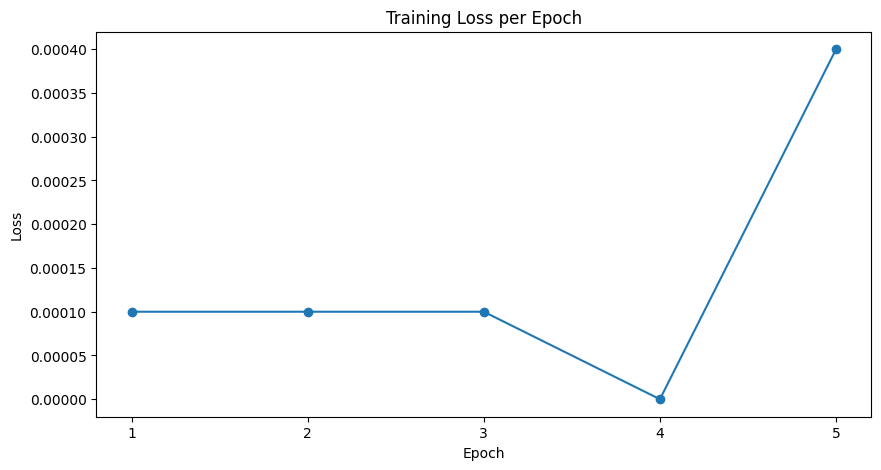

In [ ]:
save_directory = "./longformer_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

# Plot the epoch losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_logger.epoch_losses) + 1), loss_logger.epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.xticks(range(1, len(loss_logger.epoch_losses) + 1))  # Set x-axis ticks to match epoch numbers
plt.show()

### Define a Custom Longformer Model with Dropout

In [ ]:
from transformers import LongformerForTokenClassification
import torch.nn as nn

# Custom Longformer Model with Dropout
class CustomLongformerForTokenClassification(LongformerForTokenClassification):
    def __init__(self, config, dropout_rate=0.1):
        super().__init__(config)
        self.longformer = self.longformer  # Base Longformer model
        self.dropout = nn.Dropout(p=dropout_rate)  # Custom dropout rate
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)  # Classification layer

    def forward(self, input_ids, attention_mask=None, global_attention_mask=None, token_type_ids=None, labels=None):
        # Pass inputs through the Longformer model
        outputs = self.longformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask,
            token_type_ids=token_type_ids,
        )

        # Apply dropout and pass through classifier
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.config.num_labels), labels.view(-1))
            return (loss, logits)

        return logits


### Initialize Longformer and Tokenizer

In [ ]:
from transformers import AutoConfig, AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

# Define the label mappings
num_labels = len(label2id)
id2label = {v: k for k, v in label2id.items()}

# Load configuration
config = AutoConfig.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Initialize the custom Longformer model with dropout
model = CustomLongformerForTokenClassification(config, dropout_rate=0.1)
model.to(device)  # Move to GPU/CPU


CustomLongformerForTokenClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
       

### Data Collator

In [ ]:
from transformers import DataCollatorForTokenClassification

# Define data collator
data_collator = DataCollatorForTokenClassification(tokenizer)


### Define Training Arguments and Trainer

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results_longformer',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    max_grad_norm=1.0,
    logging_dir='./logs_longformer',
    logging_steps=10,
    report_to='none'
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-7a4fcbee49ab>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the Model

In [ ]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.011200,0.012178,0.997165,0.997490,0.997180,0.994677
2,0.007300,0.009056,0.997796,0.998019,0.997770,0.995793
3,0.009000,0.007941,0.997960,0.998153,0.997976,0.996133


Classification Report:
                   precision    recall  f1-score   support

B-STREET_ADDRESS       0.95      1.00      0.97        56
     B-PHONE_NUM       0.96      1.00      0.98        90
  B-NAME_STUDENT       0.72      0.44      0.55       746
I-STREET_ADDRESS       0.92      1.00      0.96       560
  I-URL_PERSONAL       1.00      1.00      1.00        24
        B-ID_NUM       0.97      0.29      0.44       104
  I-NAME_STUDENT       0.68      0.44      0.53       687
  B-URL_PERSONAL       0.92      0.96      0.94       140
     I-PHONE_NUM       0.93      1.00      0.97       183
         B-EMAIL       0.96      0.69      0.80       113
               O       1.00      1.00      1.00    475766
        I-ID_NUM       1.00      1.00      1.00        26
      B-USERNAME       1.00      0.27      0.43        22

        accuracy                           1.00    478517
       macro avg       0.92      0.78      0.81    478517
    weighted avg       1.00      1.00      1.0

TrainOutput(global_step=891, training_loss=0.023124329400835215, metrics={'train_runtime': 3349.1439, 'train_samples_per_second': 2.128, 'train_steps_per_second': 0.266, 'total_flos': 9313088207486976.0, 'train_loss': 0.023124329400835215, 'epoch': 3.0})

### Plot Training and Validation Loss

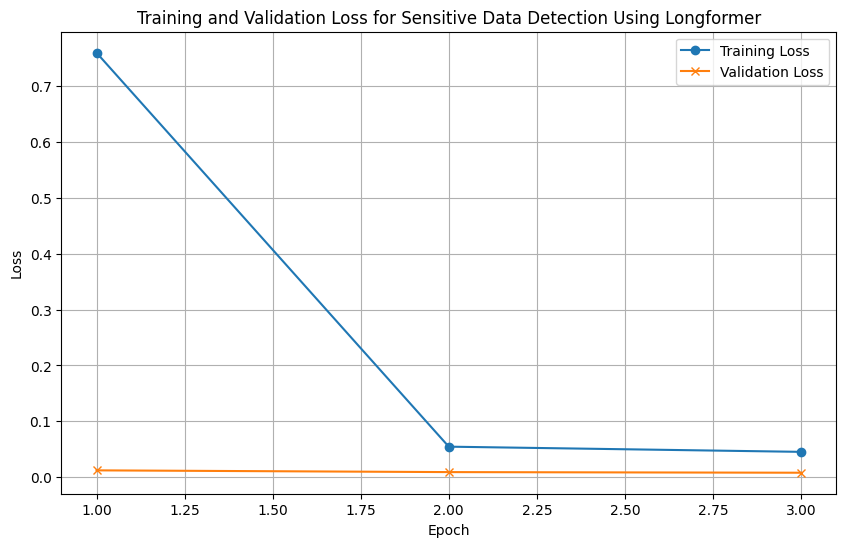

In [ ]:
# Extract training and validation loss
training_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Ensure both lists have the same length
if len(validation_losses) < len(training_losses):
    training_losses = training_losses[:len(validation_losses)]
elif len(validation_losses) > len(training_losses):
    validation_losses = validation_losses[:len(training_losses)]

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Sensitive Data Detection Using Longformer')
plt.legend()
plt.grid()
plt.show()


### Confusion Matrix for Sensitive Data Detection

Classification Report:
                   precision    recall  f1-score   support

B-STREET_ADDRESS       0.95      1.00      0.97        56
     B-PHONE_NUM       0.97      1.00      0.98        90
  B-NAME_STUDENT       0.81      0.53      0.64       746
I-STREET_ADDRESS       0.97      1.00      0.98       560
  I-URL_PERSONAL       1.00      1.00      1.00        24
        B-ID_NUM       0.96      0.62      0.75       104
  I-NAME_STUDENT       0.77      0.56      0.65       687
  B-URL_PERSONAL       0.94      0.97      0.96       140
     I-PHONE_NUM       0.97      1.00      0.98       183
         B-EMAIL       0.99      0.79      0.88       113
               O       1.00      1.00      1.00    475766
        I-ID_NUM       1.00      1.00      1.00        26
      B-USERNAME       0.96      1.00      0.98        22

        accuracy                           1.00    478517
       macro avg       0.94      0.88      0.91    478517
    weighted avg       1.00      1.00      1.0

<Figure size 1200x1000 with 0 Axes>

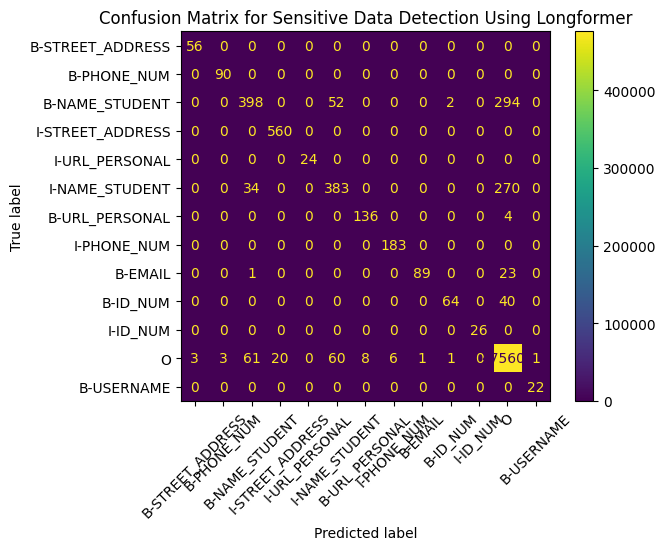

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Step 1: Get predictions from the trainer
predictions, labels, _ = trainer.predict(tokenized_datasets['test'])

# Step 2: Convert predictions to label IDs
predicted_label_ids = np.argmax(predictions, axis=2)

# Step 3: Map IDs to actual label names
true_labels = [
    [id2label[label] for label in doc if label != -100]  # Ignore padding tokens
    for doc in labels
]
pred_labels = [
    [id2label[pred] for pred, label in zip(doc, labels[i]) if label != -100]
    for i, doc in enumerate(predicted_label_ids)
]

# Step 4: Flatten the lists for confusion matrix
true_labels_flat = [label for sublist in true_labels for label in sublist]
pred_labels_flat = [label for sublist in pred_labels for label in sublist]

# Step 5: Generate confusion matrix
unique_labels = list(set(true_labels_flat + pred_labels_flat))
cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=unique_labels)

# Step 6: Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix for Sensitive Data Detection Using Longformer")
plt.show()


### Save the model


In [ ]:
import os
os.makedirs("/content/drive/My Drive/PII_models", exist_ok=True)

# Specify the output directory where the model and tokenizer should be saved
save_directory = "/content/drive/My Drive/PII_models/longformer_sensitive_data_detection_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to /content/drive/My Drive/PII_models/longformer_sensitive_data_detection_model


### Inference The Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Specify the saved directory
save_directory = "/content/drive/My Drive/PII_models/longformer_sensitive_data_detection_model"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModelForTokenClassification.from_pretrained(save_directory)

# Move model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
# Input text for inference
text = "Sensitive data like credit card numbers, addresses, or personal emails such as john.doe@gmail.com should be protected."

# Tokenize the input
tokens = tokenizer(
    text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,  # Adjust based on your model's maximum length
    is_split_into_words=False
)

# Move tokens to the same device as the model
tokens = {key: val.to(device) for key, val in tokens.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Map predictions to labels
id2label = model.config.id2label  # Ensure this mapping exists in the model configuration
predicted_labels = [id2label[label] for label in predictions[0].tolist()]
tokens_decoded = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

# Display results
print("Tokenized Input and Predictions:")
for token, label in zip(tokens_decoded, predicted_labels):
    print(f"{token}: {label}")


Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Tokenized Input and Predictions:
<s>: O
S: O
ensitive: O
Ġdata: O
Ġlike: O
Ġcredit: O
Ġcard: O
Ġnumbers: O
,: O
Ġaddresses: O
,: O
Ġor: O
Ġpersonal: O
Ġemails: O
Ġsuch: O
Ġas: O
Ġjohn: B-EMAIL
.: O
d: O
oe: O
@: O
gmail: O
.: O
com: O
Ġshould: O
Ġbe: O
Ġprotected: O
.: O
</s>: O
